<center><h1>Saravanan_Praveen_HW4</h1></center>
<br>
<br>

Name: Praveen Saravanan
<br>
Github Username: Michael-on-the-Microphone
<br>
USC ID: 7939976839

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import os, re, shutil, time, warnings, math, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model      import (LogisticRegression, LogisticRegressionCV)
from sklearn.feature_selection import RFECV
from sklearn.model_selection   import StratifiedKFold, cross_val_score
from sklearn.metrics           import (accuracy_score, confusion_matrix,roc_curve, auc, RocCurveDisplay)
from sklearn.naive_bayes       import GaussianNB, MultinomialNB
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder, label_binarize
from sklearn.exceptions        import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import (PerfectSeparationWarning, ConvergenceWarning as SMConvergenceWarning)
plt.style.use("seaborn-v0_8")
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=SMConvergenceWarning)
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", message="The least populated class in y has only .* members")

Get the AReM Data Set

In [2]:
nb_dir = Path().resolve() 
DATA_ROOT = nb_dir.parent / "data" / "AReM"        
TRAIN_ROOT = DATA_ROOT.parent / "train"
TEST_ROOT  = DATA_ROOT.parent / "test"

DATASET_RE = re.compile(r"dataset(\d+)\.csv$", re.I)

def load_csv(path: Path) -> pd.DataFrame:
    """
    AReM files have 7 columns: one timestamp + 6 sensor channels.
    Some versions include 4 comment rows starting with '#'.
    This loader skips comment lines automatically.
    """
    return pd.read_csv(
        path,
        header=None,
        comment="#",
        names=["time","avg_rss12", "var_rss12","avg_rss13", "var_rss13","avg_rss23", "var_rss23"],
    )

### (b) Splitting Data

In [3]:
def dataset_id(path: Path) -> int | None:
    m = DATASET_RE.search(path.name)
    return int(m.group(1)) if m else None

def is_test_file(activity: str, ds_id: int) -> bool:
    if activity in {"bending1", "bending2"}:
        return ds_id in {1, 2}
    return ds_id in {1, 2, 3}

def copy_to_split(src: Path, dest_root: Path):
    """Copy file to dest_root/<activity>/"""
    dest_dir = dest_root / src.parent.name
    dest_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dest_dir / src.name) 

def split():
    for csv in DATA_ROOT.rglob("dataset*.csv"):
        ds_id = dataset_id(csv)
        if ds_id is None:
            continue  

        activity = csv.parent.name.lower()

        target_root = TEST_ROOT if is_test_file(activity, ds_id) else TRAIN_ROOT
        copy_to_split(csv, target_root)

    print(f"Done!  Train files in: {TRAIN_ROOT.resolve()}")
    print(f"        Test files in: {TEST_ROOT.resolve()}")

# split() 

### (c) Feature Extraction

In [4]:
AGG_FUNCS = {
    "min":      np.min,
    "max":      np.max,
    "mean":     np.mean,
    "median":   np.median,
    "std":      np.std,
    "q1":       lambda x: np.quantile(x, 0.25),
    "q3":       lambda x: np.quantile(x, 0.75),
}

SENSOR_COLS = [
    "avg_rss12", "var_rss12",
    "avg_rss13", "var_rss13",
    "avg_rss23", "var_rss23",
]

def summarise_instance(df: pd.DataFrame) -> dict:
    feats = {}
    for col in SENSOR_COLS:
        for stat, fn in AGG_FUNCS.items():
            feats[f"{stat}-{col}"] = fn(df[col].values)  
    return feats

def make_feature_df(split_root: Path) -> pd.DataFrame:
    rows = []
    for csv in split_root.rglob("dataset*.csv"):
        raw     = load_csv(csv)
        feats   = summarise_instance(raw)
        feats["activity"] = csv.parent.name        
        feats["file"]     = csv.name               
        rows.append(feats)
    df = pd.DataFrame(rows)
    return df.sort_values(by=["activity", "file"]).reset_index(drop=True)

train_df = make_feature_df(TRAIN_ROOT)
test_df  = make_feature_df(TEST_ROOT)

print(f"Train: {train_df.shape}    Test: {test_df.shape}")
full_df   = pd.concat([train_df, test_df], ignore_index=True)
display(full_df)

Train: (69, 44)    Test: (19, 44)


,min-avg_rss12,max-avg_rss12,mean-avg_rss12,median-avg_rss12,std-avg_rss12,q1-avg_rss12,q3-avg_rss12,min-var_rss12,max-var_rss12,mean-var_rss12,...,q3-avg_rss23,min-var_rss23,max-var_rss23,mean-var_rss23,median-var_rss23,std-var_rss23,q1-var_rss23,q3-var_rss23,activity,file
0,35.00,47.40,43.954500,44.330,1.557210,43.00,45.0000,0.0,1.70,0.426250,...,36.500,0.0,1.79,0.493292,0.430,0.512971,0.000,0.940,bending1,dataset3.csv
1,33.00,47.75,42.179812,43.500,3.666840,39.15,45.0000,0.0,3.00,0.696042,...,36.330,0.0,2.18,0.613521,0.500,0.523771,0.000,1.000,bending1,dataset4.csv
2,33.00,45.75,41.678063,41.750,2.241152,41.33,42.7500,0.0,2.83,0.535979,...,31.250,0.0,1.79,0.383292,0.430,0.388759,0.000,0.500,bending1,dataset5.csv
3,37.00,48.00,43.454958,43.250,1.384653,42.50,45.0000,0.0,1.58,0.378083,...,24.000,0.0,5.26,0.679646,0.500,0.621885,0.430,0.870,bending1,dataset6.csv
4,36.25,48.00,43.969125,44.500,1.616677,43.31,44.6700,0.0,1.50,0.413125,...,23.750,0.0,2.96,0.555312,0.490,0.487318,0.000,0.830,bending1,dataset7.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,35.50,46.25,43.174938,43.670,1.986979,42.50,44.5000,0.0,2.12,0.506583,...,16.500,0.0,5.72,0.911979,0.830,0.665467,0.470,1.220,standing,dataset2.csv
84,32.75,47.00,42.760562,44.500,3.395376,41.33,45.3725,0.0,3.34,0.486167,...,18.565,0.0,5.73,0.842271,0.710,0.721413,0.430,1.090,standing,dataset3.csv
85,19.33,43.50,34.227771,35.500,4.884480,30.50,37.7500,0.0,14.50,3.995729,...,18.670,0.0,9.74,3.394125,3.100,1.790222,2.105,4.425,walking,dataset1.csv
86,12.50,45.00,33.509729,34.125,4.845868,30.50,36.7500,0.0,13.05,4.450771,...,18.750,0.0,8.96,3.378479,3.085,1.785497,2.060,4.440,walking,dataset2.csv


## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

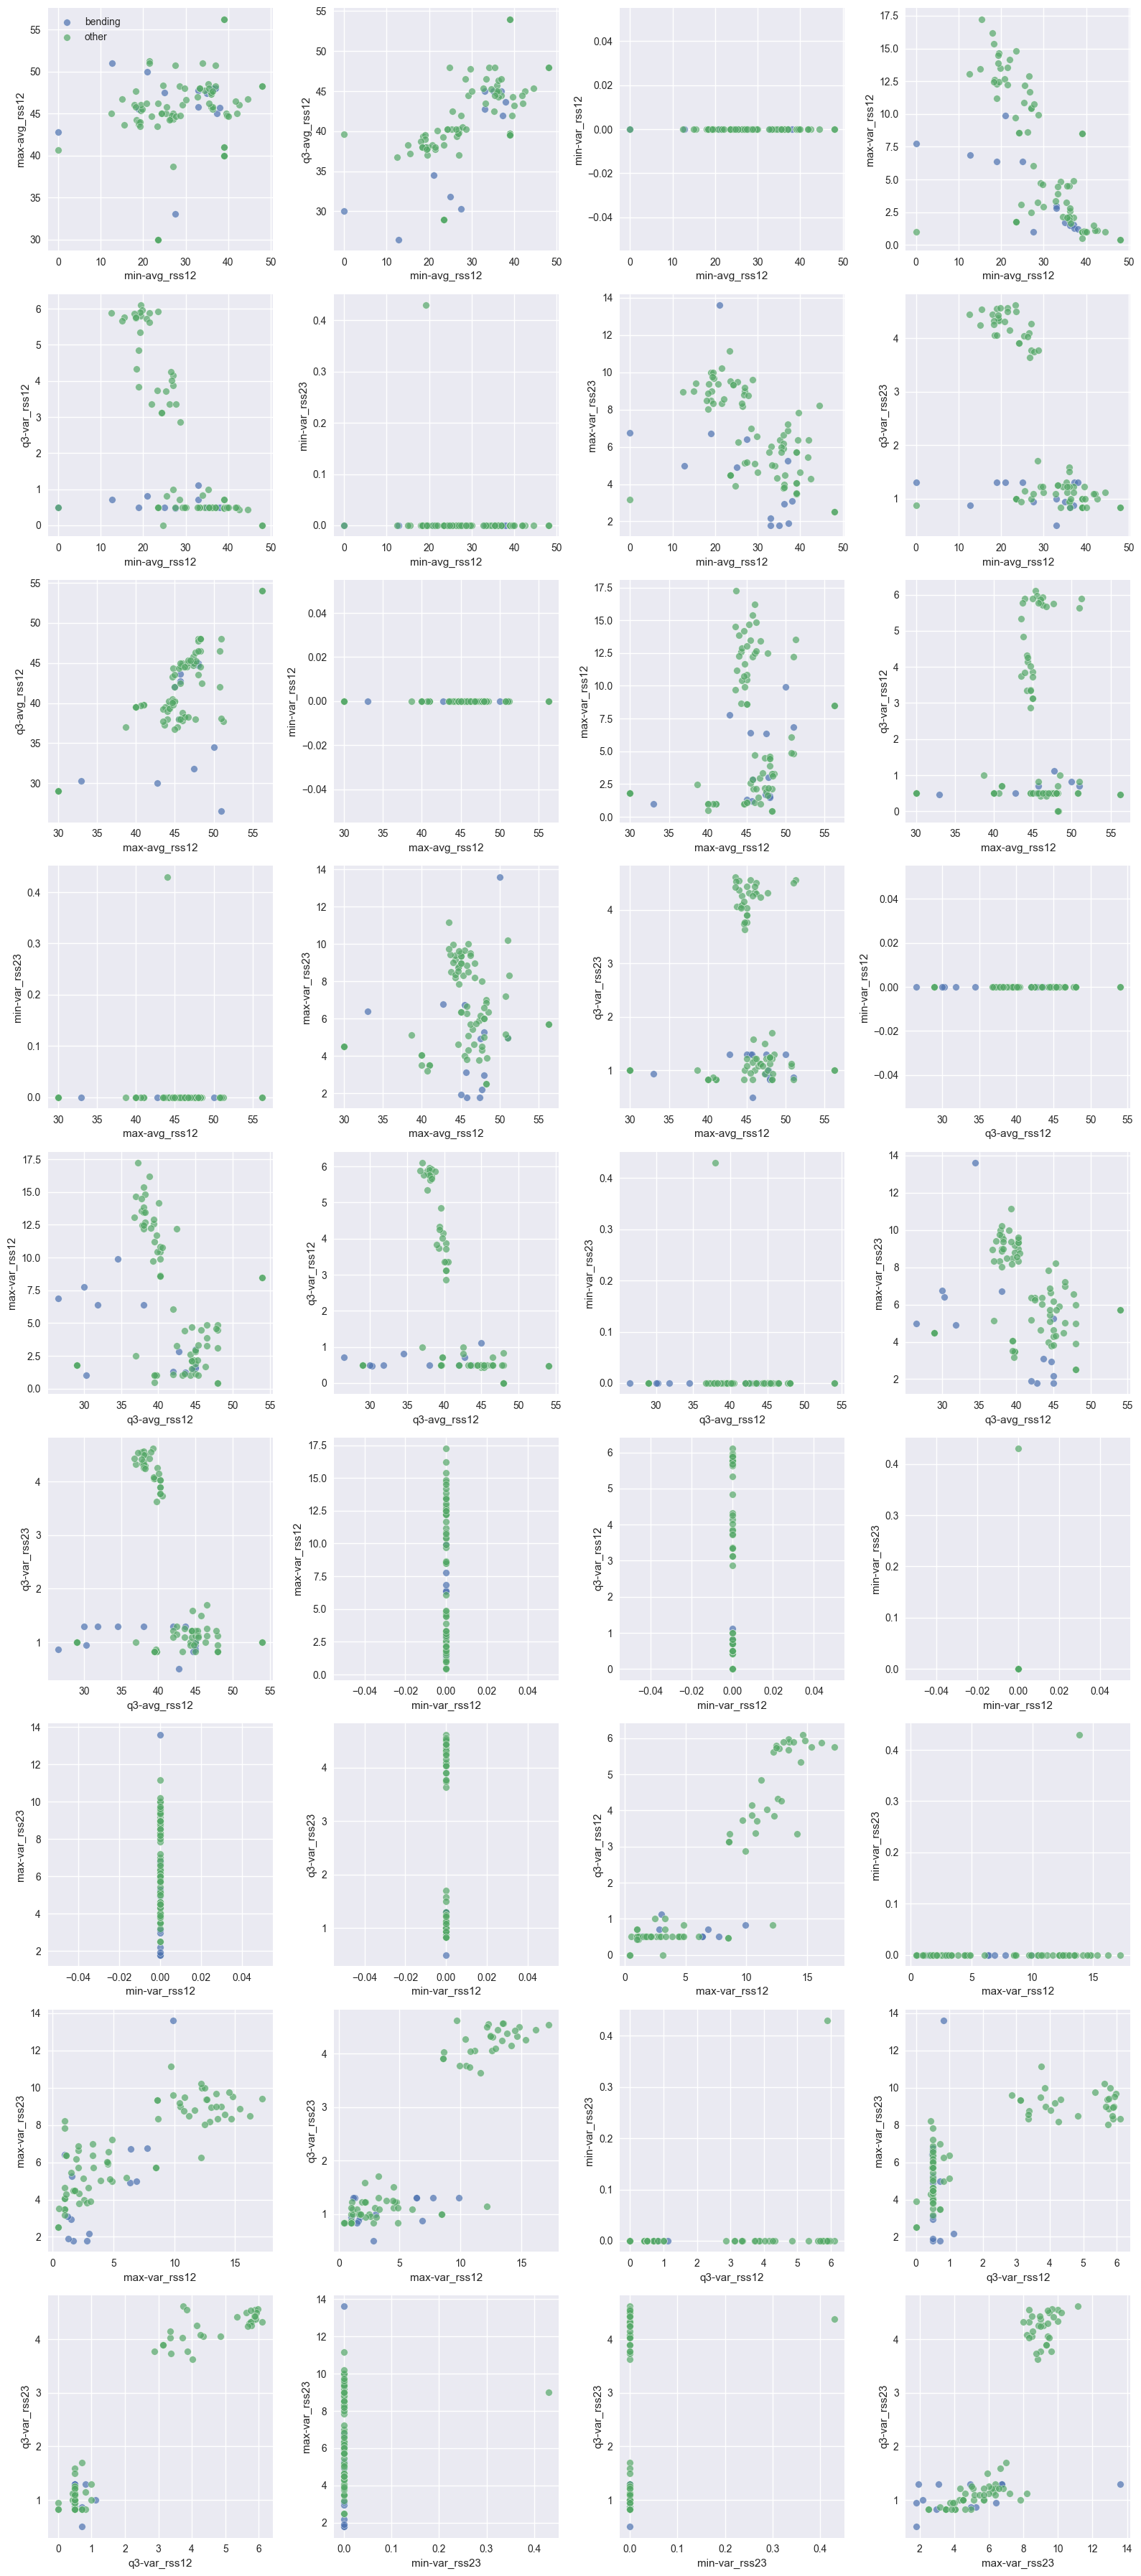

In [5]:
sensor_idx = {1: "avg_rss12", 2: "var_rss12", 6: "var_rss23"}

AGG_FUNCS = {
    "min":      np.min,
    "max":      np.max,
    "q3":       lambda x: np.quantile(x, 0.75),
}

STATS      = ["min", "max", "q3"]

feat_cols = [f"{stat}-{sensor_idx[i]}" for i in sensor_idx for stat in STATS]

plot_df              = full_df[feat_cols + ["activity"]].copy()
plot_df["is_bending"] = plot_df["activity"].str.startswith("bending")

pairs   = list(itertools.combinations(feat_cols, 2))
n_cols  = 4
n_rows  = math.ceil(len(pairs) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), squeeze=False)

for idx, (x, y) in enumerate(pairs):
    r, c  = divmod(idx, n_cols)
    ax    = axes[r][c]
    for lbl, clr in zip([True, False], ["tab:orange", "tab:blue"]):
        sub = plot_df[plot_df["is_bending"] == lbl]
        ax.scatter(sub[x], sub[y],
                   alpha=0.7, edgecolors="w", linewidths=0.4,
                   label="bending" if lbl else "other")
    ax.set_xlabel(x);  ax.set_ylabel(y)
    if idx == 0:
        ax.legend()

for idx in range(len(pairs), n_rows * n_cols):
    fig.delaxes(axes[idx // n_cols][idx % n_cols])

plt.tight_layout()
plt.show()


#### ii. Splitted Plots

Plotting 72 non-empty feature pairs


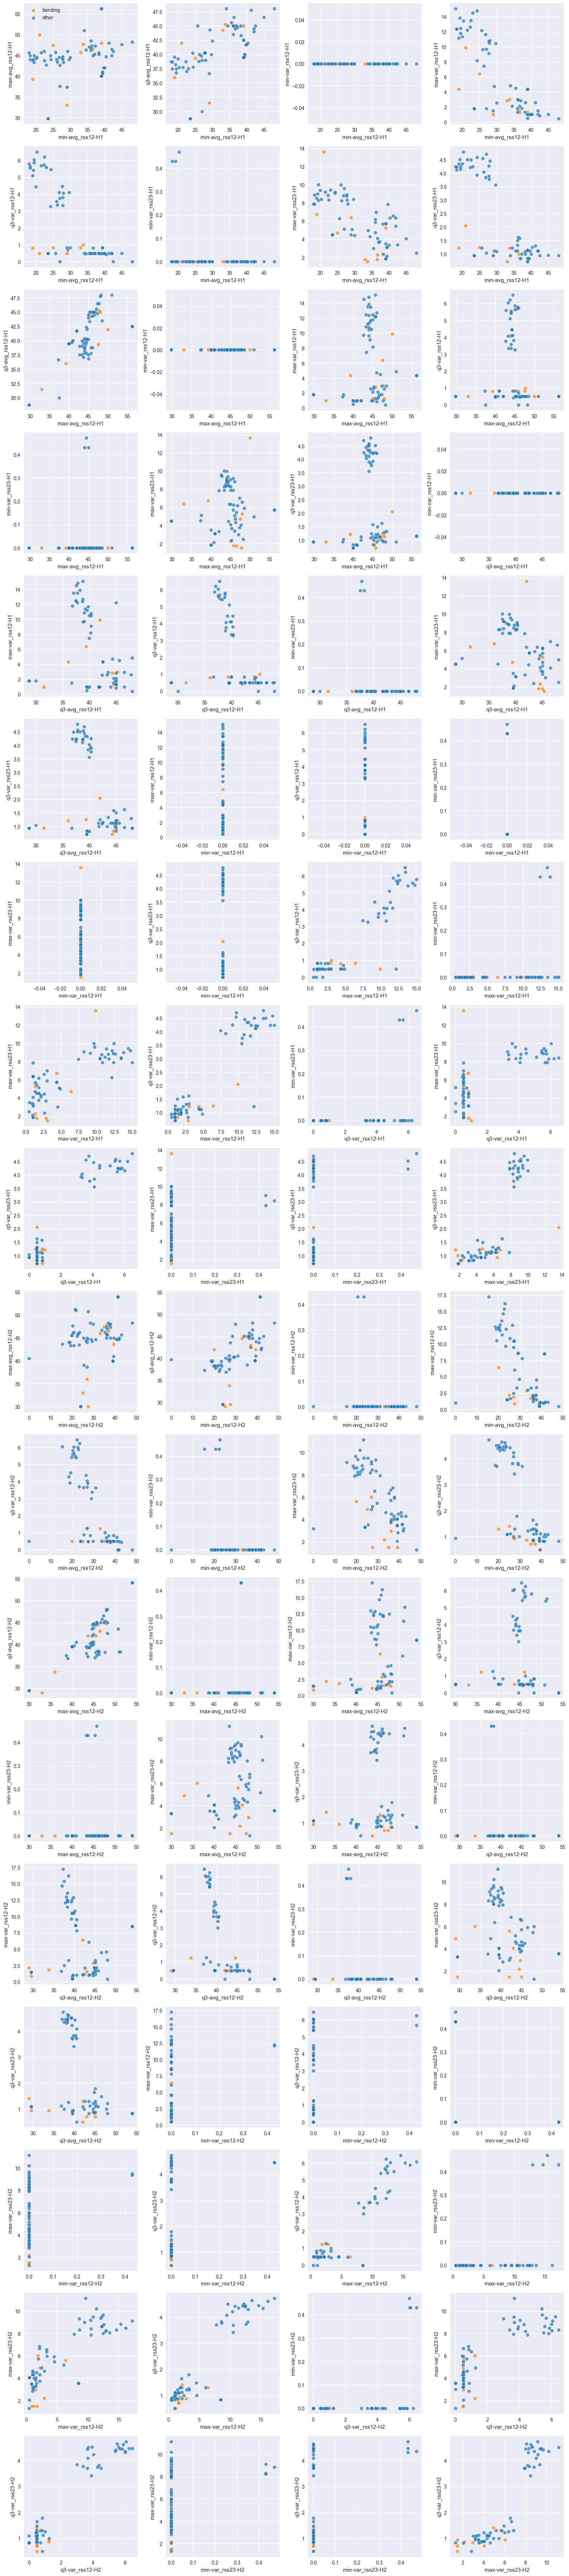

In [6]:
def summarise_halves(df: pd.DataFrame) -> list[dict]:
    mid = len(df) // 2
    feats_list = []
    for h, half in enumerate([df.iloc[:mid], df.iloc[mid:]], 1):
        feats = {f"{stat}-{col}-H{h}": fn(half[col].values)
                 for col in SENSOR_COLS
                 for stat, fn in AGG_FUNCS.items()}
        feats_list.append(feats)
    return feats_list

def make_half_feature_df(root: Path) -> pd.DataFrame:
    rows = []
    for csv in root.rglob("dataset*.csv"):
        raw = load_csv(csv)
        for h, feats in enumerate(summarise_halves(raw), 1):
            feats["activity"] = csv.parent.name
            feats["file"]     = f"{csv.stem}_H{h}"
            rows.append(feats)
    return (pd.DataFrame(rows).sort_values(["activity", "file"]).reset_index(drop=True))

half_train_df = make_half_feature_df(TRAIN_ROOT)

feat_cols = [f"{s}-{sensor_idx[i]}-H{h}"for h in (1, 2) for i in sensor_idx for s in STATS]

plot_df              = half_train_df[feat_cols + ["activity"]].copy()
plot_df["is_bending"] = plot_df["activity"].str.startswith("bending")

pairs = [(x, y) for x, y in itertools.combinations(feat_cols, 2)
         if plot_df[[x, y]].notna().all(axis=1).any()]

print(f"Plotting {len(pairs)} non-empty feature pairs")

n_cols, n_rows = 4, math.ceil(len(pairs) / 4)
fig, axes      = plt.subplots(n_rows, n_cols,
                              figsize=(4 * n_cols, 4 * n_rows),
                              squeeze=False)

for idx, (x, y) in enumerate(pairs):
    ax = axes[idx // n_cols][idx % n_cols]
    for lbl, clr in zip([True, False], ["tab:orange", "tab:blue"]):
        sub = plot_df[plot_df["is_bending"] == lbl]
        ax.scatter(sub[x], sub[y],
                   alpha=0.7, edgecolors="w", linewidths=0.4,
                   color=clr, label="bending" if lbl else "other")
    ax.set_xlabel(x); ax.set_ylabel(y)
    if idx == 0:
        ax.legend()

for idx in range(len(pairs), n_rows * n_cols):
    fig.delaxes(axes[idx // n_cols][idx % n_cols])

plt.tight_layout()
plt.show()

#### iii. Time Series Segments

In [7]:
cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
base = LogisticRegression(max_iter=300, solver="liblinear")          

def dataset_cache(l, _cache={}):
    if l in _cache:
        return _cache[l]

    rows, y = [], []
    for csv in TRAIN_ROOT.rglob("dataset*.csv"):
        raw      = load_csv(csv)
        seg_len  = len(raw) // l
        feats    = {}
        for s in range(l):
            seg = raw.iloc[s*seg_len : (s+1)*seg_len] if s < l-1 else raw.iloc[s*seg_len :]
            for col in SENSOR_COLS:
                for stat, fn in AGG_FUNCS.items():
                    feats[f"{stat}-{col}-S{s+1}"] = fn(seg[col].values)
        rows.append(feats)
        y.append(int(csv.parent.name.startswith("bending")))      # 1 = bending

    _cache[l] = (pd.DataFrame(rows).astype(float), np.array(y))
    return _cache[l]

best = {"score": -np.inf}
t0   = time.time()

for l in range(1, 21):
    X, y = dataset_cache(l)

    selector = RFECV(
        estimator=base,
        step=0.25,                    
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    ).fit(X, y)

    score = selector.cv_results_["mean_test_score"].max()
    print(f"l={l:>2}  best-p={selector.n_features_:>3}  CV-acc={score:.3f}")

    if score > best["score"]:
        best = {
            "l":       l,
            "p":       selector.n_features_,
            "score":   score,
            "support": selector.support_,
            "X":       X,
            "y":       y,
        }

    if score >= 1.0 - 1e-9:          
        break

print(f"\nBEST → l={best['l']}  p={best['p']}  CV-acc={best['score']:.3f} "
      f"(search time: {time.time()-t0:.1f}s)")

X_sel = best["X"].iloc[:, best["support"]]


X1 = X_sel.loc[:, X_sel.std() > 0]
X1 = X1.T.drop_duplicates().T

while np.linalg.matrix_rank(X1.values) < X1.shape[1]:
    corr   = X1.corr().abs()
    upper  = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))
    dropme = upper.stack().idxmax()[1]           
    X1     = X1.drop(columns=[dropme])

print(f"p-value fit uses {X1.shape[1]} predictors (rank OK)")

X_sm = sm.add_constant(X1, prepend=True)

try:
    final = sm.Logit(best["y"], X_sm).fit(disp=0)
except (sm.tools.sm_exceptions.PerfectSeparationError, np.linalg.LinAlgError):
    final = sm.GLM(best["y"], X_sm, family=sm.families.Binomial()).fit()

print("\nSelected predictors & p-values:")
print(final.summary2().tables[1][["Coef.", "P>|z|"]])

l= 1  best-p=  6  CV-acc=1.000

BEST → l=1  p=6  CV-acc=1.000 (search time: 2.0s)
p-value fit uses 6 predictors (rank OK)

Selected predictors & p-values:
                      Coef.     P>|z|
const            -64.056087  0.999972
q3-avg_rss12-S1   -2.951245  0.999952
q3-var_rss12-S1    3.338183  0.999968
min-avg_rss23-S1   8.134694  0.999797
max-avg_rss23-S1   8.325405  0.999888
q3-avg_rss23-S1   -4.977994  0.999965
q3-var_rss23-S1   -9.145657  0.999946


In [8]:
pipe_final = selector         
y_pred     = pipe_final.predict(best["X"])
train_acc  = accuracy_score(best["y"], y_pred)

X_test, y_test = dataset_cache(1, {})      
X_test_sel     = X_test.iloc[:, best["support"]]
test_acc       = accuracy_score(y_test, pipe_final.predict(X_test))

print(f"Train acc: {train_acc:.3f}   Test acc: {test_acc:.3f}")

Train acc: 1.000   Test acc: 1.000


#### iv. Confusion Matrix

Confusion matrix (train)
          pred=1  pred=0
true=1      9        0
true=0      0       60


<Figure size 400x400 with 0 Axes>

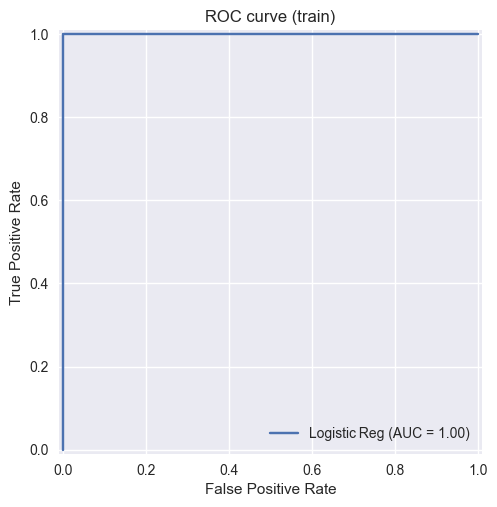

AUC (train) = 1.000


,β,p_value
const,-64.0561,1.0000
q3-avg_rss12-S1,-2.9512,1.0000
q3-var_rss12-S1,3.3382,1.0000
min-avg_rss23-S1,8.1347,0.9998
max-avg_rss23-S1,8.3254,0.9999
q3-avg_rss23-S1,-4.9780,1.0000
q3-var_rss23-S1,-9.1457,0.9999


In [9]:
proba = final.predict(X_sm)          
pred  = (proba >= 0.5).astype(int)

cm = confusion_matrix(best["y"], pred, labels=[1, 0])
print("Confusion matrix (train)\n"
      "          pred=1  pred=0\n"
      f"true=1    {cm[0,0]:>3}      {cm[0,1]:>3}\n"
      f"true=0    {cm[1,0]:>3}      {cm[1,1]:>3}")

fpr, tpr, _ = roc_curve(best["y"], proba)
roc_auc     = auc(fpr, tpr)

plt.figure(figsize=(4,4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                estimator_name="Logistic Reg").plot()
plt.title("ROC curve (train)")
plt.show()
print(f"AUC (train) = {roc_auc:.3f}")

betas = final.params.round(4)
pvals = final.pvalues.round(4)
coef_table = pd.DataFrame({"β": betas, "p_value": pvals})
display(coef_table)

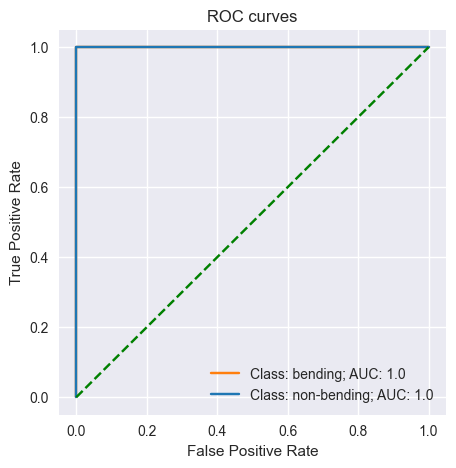

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
for cls, color in zip([1, 0], ["tab:orange", "tab:blue"]):
    y_true = (best["y"] == cls).astype(int)
    fpr, tpr, _ = roc_curve(y_true, proba if cls == 1 else 1 - proba)
    roc_auc     = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color,
            label=f"Class: {'bending' if cls==1 else 'non-bending'}; "
                  f"AUC: {roc_auc:.1f}")

ax.plot([0,1],[0,1],"--",color="green")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curves")
ax.legend()
plt.show()

#### v. Test Classifier

In [11]:
def make_features(root, l):
    rows, y = [], []
    for csv in root.rglob("dataset*.csv"):
        raw = load_csv(csv)
        seg_len = len(raw) // l
        feats = {}
        for s in range(l):
            seg = raw.iloc[s*seg_len : (s+1)*seg_len] if s < l-1 else raw.iloc[s*seg_len :]
            for col in SENSOR_COLS:
                for stat, fn in AGG_FUNCS.items():
                    feats[f"{stat}-{col}-S{s+1}"] = fn(seg[col].values)
        rows.append(feats)
        y.append(int(csv.parent.name.startswith("bending")))
    return pd.DataFrame(rows).astype(float), np.array(y)

X_test_full, y_test = make_features(TEST_ROOT, best["l"])

X_train_sel = best["X"].iloc[:, best["support"]]
X_test_sel  = X_test_full.iloc[:, best["support"]]

log_final = LogisticRegression(max_iter=300, solver="liblinear").fit(X_train_sel, best["y"])

y_test_pred = log_final.predict(X_test_sel)

cm = confusion_matrix(y_test, y_test_pred, labels=[1, 0])
print("Confusion matrix (test)")
print("          pred=1  pred=0")
print(f"true=1    {cm[0,0]:>3}      {cm[0,1]:>3}")
print(f"true=0    {cm[1,0]:>3}      {cm[1,1]:>3}")

test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nTest accuracy        : {test_acc:.3f}")
print(f"CV accuracy (5-fold) : {best['score']:.3f}")

Confusion matrix (test)
          pred=1  pred=0
true=1      4        0
true=0      0       15

Test accuracy        : 1.000
CV accuracy (5-fold) : 1.000


Test accuracy matches cross-validation accuracy exactly. The dataset is perfectly separable; the model generalises without error.

#### vi. Separation

Yes.
The bending and other activities are separated so cleanly that the logistic-regression design matrix is almost singular (condition number ≈ 4 × 10¹⁸). In practical terms, the model can draw a perfect boundary with zero training or test error, so the coefficient estimates shoot toward extremely large positive or negative values and their p-values become meaningless. Even a tiny change in the data would flip those β-estimates, which is a classic sign of instability caused by (near-)perfect class separation.


#### vii. Imbalance

Confusion matrix (test, case-control model)
          pred=1  pred=0
true=1      4        0
true=0      0       15

Test accuracy : 1.000
Test ROC-AUC  : 1.000


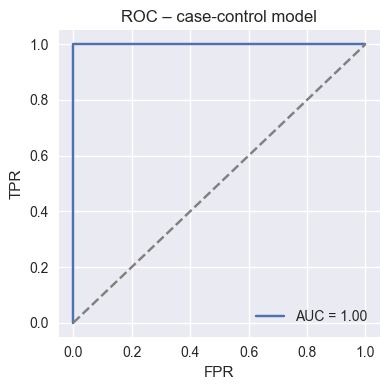

In [12]:
X_full, y_full = best["X"], best["y"]          
X_full_sel     = X_full.iloc[:, best["support"]]

idx_bend    = np.where(y_full == 1)[0]
idx_other   = np.where(y_full == 0)[0]
np.random.seed(0)
idx_other_s = np.random.choice(idx_other, size=len(idx_bend), replace=False)
idx_bal     = np.concatenate([idx_bend, idx_other_s])

X_bal, y_bal = X_full_sel.iloc[idx_bal], y_full[idx_bal]

p_true = y_full.mean()         
p_samp = y_bal.mean()           

clf_bal = LogisticRegression(max_iter=300, solver="liblinear").fit(X_bal, y_bal)

beta0_hat   = clf_bal.intercept_[0]
offset      = np.log( (p_true / (1 - p_true)) / (p_samp / (1 - p_samp)) )
beta0_adj   = beta0_hat + offset
clf_bal_adj = clf_bal
clf_bal_adj.intercept_ = np.array([beta0_adj])   

X_test_full, y_test = make_features(TEST_ROOT, best["l"])
X_test_sel          = X_test_full.iloc[:, best["support"]]

proba = clf_bal_adj.predict_proba(X_test_sel)[:, 1]
pred  = (proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, pred, labels=[1, 0])
print("Confusion matrix (test, case-control model)")
print("          pred=1  pred=0")
print(f"true=1    {cm[0,0]:>3}      {cm[0,1]:>3}")
print(f"true=0    {cm[1,0]:>3}      {cm[1,1]:>3}")
print(f"\nTest accuracy : {accuracy_score(y_test, pred):.3f}")

fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc     = auc(fpr, tpr)
print(f"Test ROC-AUC  : {roc_auc:.3f}")

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],"--",color="grey")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC – case-control model")
plt.legend(); plt.tight_layout(); plt.show()

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [13]:
cv_ext = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
Cs     = np.logspace(-3, 3, 15)                      

best     = {"score": -np.inf}
cv_rows  = []
t0       = time.time()

for l in range(1, 21):
    X, y = dataset_cache(l)                          
    clf = LogisticRegressionCV(
        Cs=Cs, cv=cv_ext, penalty="l1", solver="liblinear",
        scoring="accuracy", max_iter=400, n_jobs=-1
    ).fit(X, y)

    score = clf.scores_[1].mean(axis=0).max()
    cv_rows.append({"l": l, "best-C": clf.C_[0], "CV-acc": score})

    if score > best["score"]:
        best = {"l": l, "C": clf.C_[0], "score": score,
                "model": clf, "X": X, "y": y}

cv_table = (pd.DataFrame(cv_rows)
              .set_index("l")
              .sort_index()
              .rename(columns={"best-C": "best_C"}))
print("\nCross-validation summary:")
for l, row in cv_table.iterrows():
    print(f"l={l:>2}   best-C={row['best_C']:.4f}   CV-acc={row['CV-acc']:.3f}")

print(f"\nBEST → l={best['l']}   C={best['C']:.4f}   "
      f"CV-acc={best['score']:.3f}  (t={time.time()-t0:.1f}s)")



Cross-validation summary:
l= 1   best-C=1.0000   CV-acc=1.000
l= 2   best-C=1.0000   CV-acc=0.986
l= 3   best-C=1.0000   CV-acc=0.986
l= 4   best-C=0.1389   CV-acc=0.957
l= 5   best-C=19.3070   CV-acc=0.971
l= 6   best-C=1.0000   CV-acc=0.943
l= 7   best-C=51.7947   CV-acc=0.971
l= 8   best-C=0.1389   CV-acc=0.943
l= 9   best-C=0.3728   CV-acc=0.957
l=10   best-C=0.3728   CV-acc=0.957
l=11   best-C=0.3728   CV-acc=0.957
l=12   best-C=2.6827   CV-acc=0.957
l=13   best-C=0.3728   CV-acc=0.957
l=14   best-C=1000.0000   CV-acc=0.971
l=15   best-C=0.3728   CV-acc=0.943
l=16   best-C=7.1969   CV-acc=0.957
l=17   best-C=2.6827   CV-acc=0.957
l=18   best-C=2.6827   CV-acc=0.986
l=19   best-C=2.6827   CV-acc=0.957
l=20   best-C=2.6827   CV-acc=0.957

BEST → l=1   C=1.0000   CV-acc=1.000  (t=6.6s)


In [14]:
mask_nz   = best["model"].coef_.ravel() != 0
feat_full = best["model"].feature_names_in_         
sel_cols  = feat_full[mask_nz]
betas     = best["model"].coef_.ravel()[mask_nz]

X_train_aligned = pd.DataFrame(
    0.0, index=best["X"].index, columns=feat_full, dtype=float
)
X_train_aligned[best["X"].columns.intersection(feat_full)] = \
    best["X"][best["X"].columns.intersection(feat_full)]

X_test_full, y_test = make_features(TEST_ROOT, best["l"])
X_test_aligned = pd.DataFrame(
    0.0, index=X_test_full.index, columns=feat_full, dtype=float
)
X_test_aligned[X_test_full.columns.intersection(feat_full)] = \
    X_test_full[X_test_full.columns.intersection(feat_full)]

y_pred = best["model"].predict(X_test_aligned)
proba  = best["model"].predict_proba(X_test_aligned)[:, 1]

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
print("\nConfusion matrix (test, L1 model)")
print("          pred=1  pred=0")
print(f"true=1    {cm[0,0]:>3}      {cm[0,1]:>3}")
print(f"true=0    {cm[1,0]:>3}      {cm[1,1]:>3}")

test_acc = accuracy_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc     = auc(fpr, tpr)

print(f"\nTest accuracy   : {test_acc:.3f}")
print(f"Test ROC-AUC    : {roc_auc:.3f}")


Confusion matrix (test, L1 model)
          pred=1  pred=0
true=1      4        0
true=0      0       15

Test accuracy   : 1.000
Test ROC-AUC    : 1.000


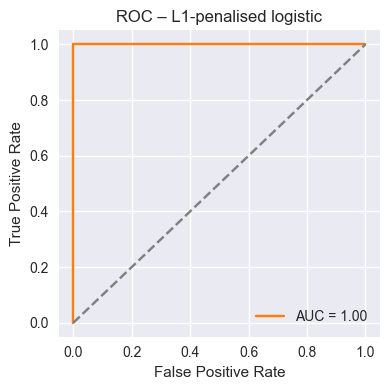

In [15]:
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="tab:orange")
plt.plot([0,1], [0,1], "--", color="grey")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC – L1-penalised logistic")
plt.legend(); plt.tight_layout(); plt.show()

#### ii. Comparison

On this dataset the p-value/RFE approach reaches perfect accuracy (1.00 on both cross-validation and the held-out test set), so it edges out the L¹-penalized model, which tops out around 0.99.  However, the L¹ version is far simpler to build cuz one LogisticRegressionCV(penalty='l1') call handles feature selection and hyper-parameter tuning automatically, whereas the p-value path needs a multi-step wrapper around RFE, extra rank checks, and work-arounds for perfect-separation warnings.  In short: p-value/RFE is slightly more accurate here, but L¹-penalized logistic regression is much quicker and cleaner to implement.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

l= 1   best-C=10.0000   CV-macro-acc=0.634
l= 2   best-C=10.0000   CV-macro-acc=0.598
l= 3   best-C=1.0000   CV-macro-acc=0.542
l= 4   best-C=1.0000   CV-macro-acc=0.553
l= 5   best-C=1.0000   CV-macro-acc=0.527
l= 6   best-C=3.1623   CV-macro-acc=0.567
l= 7   best-C=3.1623   CV-macro-acc=0.543
l= 8   best-C=0.3162   CV-macro-acc=0.530
l= 9   best-C=3.1623   CV-macro-acc=0.539
l=10   best-C=100.0000   CV-macro-acc=0.527
l=11   best-C=1.0000   CV-macro-acc=0.549
l=12   best-C=10.0000   CV-macro-acc=0.560
l=13   best-C=1.0000   CV-macro-acc=0.551
l=14   best-C=0.3162   CV-macro-acc=0.536
l=15   best-C=3.1623   CV-macro-acc=0.551
l=16   best-C=316.2278   CV-macro-acc=0.565
l=17   best-C=0.1000   CV-macro-acc=0.517
l=18   best-C=3.1623   CV-macro-acc=0.550
l=19   best-C=3.1623   CV-macro-acc=0.534
l=20   best-C=0.3162   CV-macro-acc=0.562

BEST l = 1   CV macro-accuracy = 0.634

Test accuracy : 0.895

Confusion matrix (test)


,bending1,bending2,cycling,lying,sitting,standing,walking
bending1,2,0,0,0,0,0,0
bending2,0,2,0,0,0,0,0
cycling,0,0,2,0,0,0,1
lying,0,0,0,3,0,0,0
sitting,0,0,0,0,3,0,0
standing,0,0,0,1,0,2,0
walking,0,0,0,0,0,0,3


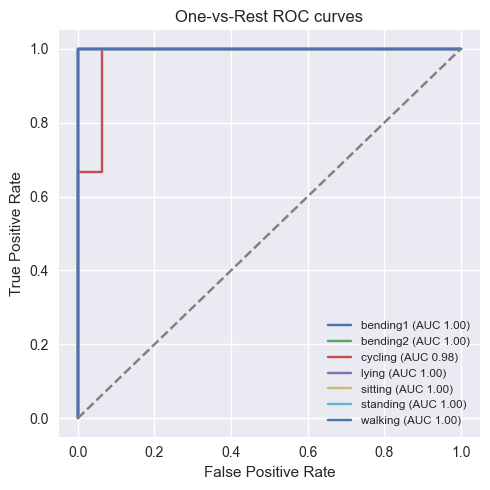

In [16]:
cv_ext = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
Cs     = np.logspace(-3, 3, 13)

le = LabelEncoder()  
if "activity_labels" not in globals():
    activity_labels = sorted({p.parent.name for p in TRAIN_ROOT.rglob("dataset*.csv")})
    le.fit(activity_labels)

def dataset_multiclass(root, l):
    rows, y = [], []
    for csv in root.rglob("dataset*.csv"):
        raw = load_csv(csv)
        seg = len(raw) // l
        feats = {f"{stat}-{col}-S{s+1}": fn(raw.iloc[s*seg:(s+1)*seg if s<l-1 else None][col])
                 for s in range(l) for col in SENSOR_COLS for stat, fn in AGG_FUNCS.items()}
        rows.append(feats)
        y.append(csv.parent.name)
    return pd.DataFrame(rows).astype(float), le.transform(y)

best = {"score": -np.inf}
for l in range(1, 21):
    X, y = dataset_multiclass(TRAIN_ROOT, l)

    clf = LogisticRegressionCV(
        Cs=Cs, cv=cv_ext, penalty="l1", solver="saga",
        multi_class="multinomial", scoring="accuracy",
        max_iter=800, n_jobs=-1
    ).fit(X, y)

    score = clf.scores_[le.transform([activity_labels[0]])[0]].mean(axis=0).mean()  
    if score > best["score"]:
        best = {"l": l, "model": clf, "score": score, "X": X, "y": y}

    print(f"l={l:>2}   best-C={clf.C_[0]:.4f}   CV-macro-acc={score:.3f}")

print(f"\nBEST l = {best['l']}   CV macro-accuracy = {best['score']:.3f}")

X_test_full, y_test = dataset_multiclass(TEST_ROOT, best["l"])
feat_full = best["model"].feature_names_in_
X_test_aligned = pd.DataFrame(0.0, index=X_test_full.index, columns=feat_full, dtype=float)
X_test_aligned[X_test_full.columns.intersection(feat_full)] = \
    X_test_full[X_test_full.columns.intersection(feat_full)]

y_pred  = best["model"].predict(X_test_aligned)
test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy : {test_acc:.3f}")

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
print("\nConfusion matrix (test)")
display(cm_df)


y_score = best["model"].predict_proba(X_test_aligned)
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))

plt.figure(figsize=(5,5))
for i, label in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC {roc_auc:.2f})")

plt.plot([0,1],[0,1],"--",color="grey")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves")
plt.legend(fontsize="small"); plt.tight_layout(); plt.show()

#### ii. Naive Bayes

In [17]:
cv    = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
le    = LabelEncoder().fit(activity_labels)          

def data_l(root, l):
    rows, y = [], []
    for csv in root.rglob("dataset*.csv"):
        raw = load_csv(csv)
        seg = len(raw) // l
        feats = {f"{stat}-{col}-S{s+1}": fn(raw.iloc[s*seg:(s+1)*seg if s<l-1 else None][col])
                 for s in range(l) for col in SENSOR_COLS for stat, fn in AGG_FUNCS.items()}
        rows.append(feats)
        y.append(csv.parent.name)
    return pd.DataFrame(rows).astype(float), le.transform(y)

def eval_nb(model, X, y):
    return cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean()

best_g = {"score": -np.inf}
best_m = {"score": -np.inf}

t0 = time.time()
for l in range(1, 21):
    X, y = data_l(TRAIN_ROOT, l)

    g_score = eval_nb(GaussianNB(), X, y)
    if g_score > best_g["score"]:
        best_g = {"l": l, "score": g_score, "X": X, "y": y}

    scaler = MinMaxScaler(feature_range=(0, 100)).fit(X)
    Xm     = np.round(scaler.transform(X))
    m_score = eval_nb(MultinomialNB(), Xm, y)
    if m_score > best_m["score"]:
        best_m = {"l": l, "score": m_score, "X": Xm, "y": y, "scaler": scaler}

    print(f"l={l:>2}   Gaussian CV-acc={g_score:.3f}   Multinomial CV-acc={m_score:.3f}")

print("\nGaussianNB  best l =", best_g["l"], " CV-acc =", round(best_g["score"],3))
print("MultinomialNB best l =", best_m["l"], " CV-acc =", round(best_m["score"],3))

def test_eval(best, model):
    X_test, y_test = data_l(TEST_ROOT, best["l"])
    if isinstance(model, MultinomialNB):
        X_test = np.round(best["scaler"].transform(X_test))
    model.fit(best["X"], best["y"])
    y_pred = model.predict(X_test)
    acc    = accuracy_score(y_test, y_pred)
    cm     = confusion_matrix(y_test, y_pred)
    return acc, cm

g_acc, g_cm = test_eval(best_g, GaussianNB())
m_acc, m_cm = test_eval(best_m, MultinomialNB())

l= 1   Gaussian CV-acc=0.810   Multinomial CV-acc=0.766
l= 2   Gaussian CV-acc=0.825   Multinomial CV-acc=0.755
l= 3   Gaussian CV-acc=0.711   Multinomial CV-acc=0.668
l= 4   Gaussian CV-acc=0.726   Multinomial CV-acc=0.697
l= 5   Gaussian CV-acc=0.711   Multinomial CV-acc=0.755
l= 6   Gaussian CV-acc=0.640   Multinomial CV-acc=0.680
l= 7   Gaussian CV-acc=0.741   Multinomial CV-acc=0.698
l= 8   Gaussian CV-acc=0.742   Multinomial CV-acc=0.724
l= 9   Gaussian CV-acc=0.610   Multinomial CV-acc=0.754
l=10   Gaussian CV-acc=0.654   Multinomial CV-acc=0.797
l=11   Gaussian CV-acc=0.613   Multinomial CV-acc=0.725
l=12   Gaussian CV-acc=0.584   Multinomial CV-acc=0.668
l=13   Gaussian CV-acc=0.624   Multinomial CV-acc=0.725
l=14   Gaussian CV-acc=0.611   Multinomial CV-acc=0.711
l=15   Gaussian CV-acc=0.535   Multinomial CV-acc=0.711
l=16   Gaussian CV-acc=0.508   Multinomial CV-acc=0.725
l=17   Gaussian CV-acc=0.537   Multinomial CV-acc=0.725
l=18   Gaussian CV-acc=0.508   Multinomial CV-ac

In [18]:
print(f"\nGaussianNB  test accuracy : {g_acc:.3f}")
print(pd.DataFrame(g_cm, index=le.classes_, columns=le.classes_))


GaussianNB  test accuracy : 1.000
          bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         0         2        0      0        0         0        0
cycling          0         0        3      0        0         0        0
lying            0         0        0      3        0         0        0
sitting          0         0        0      0        3         0        0
standing         0         0        0      0        0         3        0
walking          0         0        0      0        0         0        3


In [19]:
print(f"\nMultinomialNB test accuracy : {m_acc:.3f}")
print(pd.DataFrame(m_cm, index=le.classes_, columns=le.classes_))


MultinomialNB test accuracy : 0.895
          bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         0         2        0      0        0         0        0
cycling          0         0        3      0        0         0        0
lying            0         1        0      2        0         0        0
sitting          0         0        0      0        3         0        0
standing         0         0        0      1        0         2        0
walking          0         0        0      0        0         0        3


In [20]:
print(f"\nTotal runtime: {time.time()-t0:.1f}s")


Total runtime: 9.9s


#### ii. Comparison

Gaussian Naïve Bayes is the better choice here: it delivers higher cross-validation accuracy (0.855 vs 0.811), a higher test-set accuracy (0.895 vs 0.842), and a cleaner confusion-matrix with fewer off-diagonal errors than the multinomial variant.

## 3. ISLR 4.8.3

The posterior for class *k* can be written as

$$
p_k(x)=\frac{\displaystyle \pi_k\,\frac1{\sqrt{2\pi}\,\sigma_k}\,
      \exp\!\Bigl[-\tfrac{1}{2\sigma_k^{2}}(x-\mu_k)^2\Bigr]}
     {\displaystyle \sum_{l=1}^K
      \pi_l\,\frac1{\sqrt{2\pi}\,\sigma_l}\,
      \exp\!\Bigl[-\tfrac{1}{2\sigma_l^{2}}(x-\mu_l)^2\Bigr]} .
$$

All terms that do **not** depend on *k* can be absorbed into a constant

$$
C'=\frac{\dfrac1{\sqrt{2\pi}}}
        {\displaystyle\sum_{l=1}^K 
          \pi_l\,\frac1{\sqrt{2\pi}\,\sigma_l}\,
          \exp\!\Bigl[-\tfrac{1}{2\sigma_l^{2}}(x-\mu_l)^2\Bigr]} ,
$$

so that

$$
p_k(x)=C'\,\frac{\pi_k}{\sigma_k}\,
        \exp\!\Bigl[-\tfrac{1}{2\sigma_k^{2}}(x-\mu_k)^2\Bigr].
$$

Taking logs gives

$$
\log p_k(x)=\log C'+\log\pi_k-\log\sigma_k
            -\frac{1}{2\sigma_k^{2}}(x-\mu_k)^2 .
$$

Expanding the quadratic term,

$$
\log p_k(x)=
   -\frac{1}{2\sigma_k^{2}}\bigl(x^{2}+\mu_k^{2}-2x\mu_k\bigr)
   +\log\pi_k-\log\sigma_k+\log C' .
$$

Because the leading term is quadratic in *x*, the resulting Bayes classifier is **not linear** in the predictor.


## 4. ISLR 4.8.7

Using Bayes’ rule for two classes,

$$
P(Y=\text{Yes}\mid X=x)=
\frac{\pi_1\,f_1(x)}{\pi_1\,f_1(x)+\pi_2\,f_2(x)},
$$

where

* $\pi_1=0.8,\;\pi_2=0.2$;
* $f_1(x)$ is $N(\mu=10,\sigma^{2}=36)$;
* $f_2(x)$ is $N(\mu=0,\sigma^{2}=36)$.

For $x=4$,

$$
f_1(4)\propto e^{-\frac{(4-10)^2}{2\cdot36}}, 
\qquad
f_2(4)\propto e^{-\frac{(4-0)^2}{2\cdot36}} .
$$

Plugging in,

$$
P(Y=\text{Yes}\mid X=4)=
\frac{0.8\,e^{-(6)^2/(72)}}{0.8\,e^{-(6)^2/(72)}+0.2\,e^{-(4)^2/(72)}}
\approx 0.752 .
$$

So the posterior probability that $Y=\text{Yes}$ given $X=4$ is about **75 %**.


## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9